In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

In [ ]:
data = pd.read_csv('dataset.csv')
input_texts = data['English words/sentences'].values
target_texts = data['French words/sentences'].values

# Cut the data to work faster, for now!
input_texts = input_texts[:5000]
target_texts = target_texts[:5000]

In [ ]:
input_texts.shape, target_texts.shape

((5000,), (5000,))

In [ ]:
eng_tokenizer = Tokenizer(filters='')
eng_tokenizer.fit_on_texts(input_texts)
eng_sequences = eng_tokenizer.texts_to_sequences(input_texts)
eng_vocab_size = len(eng_tokenizer.word_index) + 1
max_eng_len = max(len(seq) for seq in eng_sequences)

fra_tokenizer = Tokenizer(filters='')
fra_tokenizer.fit_on_texts(target_texts)
fra_sequences = fra_tokenizer.texts_to_sequences(target_texts)
fra_vocab_size = len(fra_tokenizer.word_index) + 1
max_fra_len = max(len(seq) for seq in fra_sequences)

# Save the tokenizer for later use and for consistency
import pickle
with open('eng_tokenizer.pkl', 'wb') as f:
    pickle.dump(eng_tokenizer, f)
with open('fra_tokenizer.pkl', 'wb') as f:
    pickle.dump(fra_tokenizer, f)

    #When you need to use the model for inference (translating new sentences), you’ll need the same tokenizers that were used during training to convert new input data into sequences that match the model’s expected format.
#Consistency: It ensures the input data is tokenized in the exact same way (same word-to-index mapping), which is critical for generating meaningful outputs.
#pickle is typically used for saving objects like tokenizers or trained models, not for saving dynamic states like GRU hidden states

In [ ]:
# Pad
eng_sequences = pad_sequences(eng_sequences, maxlen=max_eng_len, padding='post')
fra_sequences = pad_sequences(fra_sequences, maxlen=max_fra_len, padding='post')

# Split
fra_input_sequences = fra_sequences[:, :-1]
fra_output_sequences = fra_sequences[:, 1:]

In [ ]:
# Model HPs
embedding_dim = 256
latent_dim = 512

In [ ]:
# Encoder
encoder_inputs = Input(shape=(max_eng_len,))
encoder_embedding = Embedding(eng_vocab_size, embedding_dim)(encoder_inputs)
encoder_lstm, state_h, state_c = LSTM(latent_dim, return_state=True)(encoder_embedding) #The cell state in LSTM (Long Short-Term Memory) is a crucial component for preserving long-term dependencies.
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_fra_len-1,))
decoder_embedding = Embedding(fra_vocab_size, embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
# Build model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(
    optimizer=Adam(learning_rate=0.1),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', 'sparse_categorical_crossentropy'],
)

In [ ]:
# Print summary of model in extreme detail
model.summary(
    expand_nested=True,
    show_trainable=True,
    line_length=100,
    positions=[.33, .55, .67, 1.]
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)               ┃ Output Shape      ┃  Param # ┃ Connected to               ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_2 (InputLayer) │ (None, 5)         │        0 │ -                          │    -    │
├────────────────────────────┼───────────────────┼──────────┼────────────────────────────┼─────────┤
│ input_layer_3 (InputLayer) │ (None, 9)         │        0 │ -                          │    -    │
├────────────────────────────┼───────────────────┼──────────┼────────────────────────────┼─────────┤
│ embedding_2 (Embedding)    │ (None, 5, 256)    │  431,360 │ input_layer_2[0][0]        │    Y    │
├────────────────────────────┼───────────────────┼──────────┼────────────────────────────┼─────────┤
│ embedding_3 (Embedding)    │ (None, 9, 256)    │  864,256 │ input_layer_3[0][0]        │    Y    │
├────────────────────────────┼───────────────────┼──────────┼────────────────────────────┼─────────┤
│ lstm_2 (LSTM)              │ [(None, 512),     │ 1,574,9… │ embedding_2[0][0]          │    Y    │
│                            │ (None, 512),      │          │                            │         │
│                            │ (None, 512)]      │          │                            │         │
├────────────────────────────┼───────────────────┼──────────┼────────────────────────────┼─────────┤
│ lstm_3 (LSTM)              │ [(None, 9, 512),  │ 1,574,9… │ embedding_3[0][0],         │    Y    │
│                            │ (None, 512),      │          │ lstm_2[0][1], lstm_2[0][2] │         │
│                            │ (None, 512)]      │          │                            │         │
├────────────────────────────┼───────────────────┼──────────┼────────────────────────────┼─────────┤
│ dense_1 (Dense)            │ (None, 9, 3376)   │ 1,731,8… │ lstm_3[0][0]               │    Y    │
└────────────────────────────┴───────────────────┴──────────┴────────────────────────────┴─────────┘

 Total params: 6,177,328 (23.56 MB)

 Trainable params: 6,177,328 (23.56 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = keras.callbacks.ModelCheckpoint('seq2seq_lstm.keras', save_best_only=True)

def scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.1))

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

tensorboard = keras.callbacks.TensorBoard(log_dir='logs')

history = model.fit(
    [eng_sequences, fra_input_sequences],
    np.expand_dims(fra_output_sequences, -1),
    epochs=20,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler, tensorboard]
)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.3367 - loss: 16.7789 - sparse_categorical_crossentropy: 16.7789 - val_accuracy: 0.6240 - val_loss: 36.2849 - val_sparse_categorical_crossentropy: 36.2849 - learning_rate: 0.0905
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6788 - loss: 24.1159 - sparse_categorical_crossentropy: 24.1159 - val_accuracy: 0.7201 - val_loss: 4.7736 - val_sparse_categorical_crossentropy: 4.7736 - learning_rate: 0.0819
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.7721 - loss: 2.4575 - sparse_categorical_crossentropy: 2.4575 - val_accuracy: 0.7578 - val_loss: 2.5216 - val_sparse_categorical_crossentropy: 2.5216 - learning_rate: 0.0741
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.7924 - loss: 1.4184 - sparse_categorical_crossentropy: 1.4184 - val_accuracy: 0.7583 - val_loss: 2.3895 - val_sparse_categorical_crossentropy: 2.3895 - learning_rate: 0.0670
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 

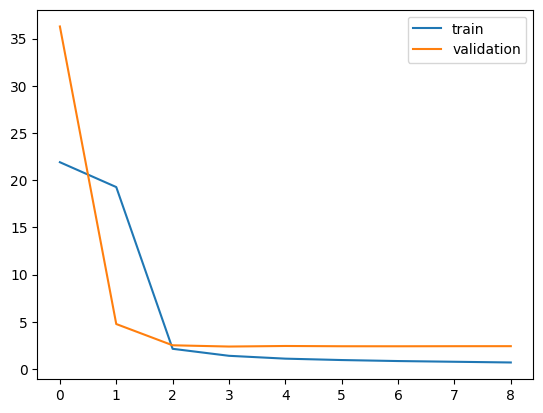

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()